In [ ]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader.git

Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Receiving objects: 100% (24/24), 6.34 MiB | 19.98 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
import matplotlib.pyplot as plt
from HodaDatasetReader.HodaDatasetReader import read_hoda_dataset

In [ ]:
X_train, y_train = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Train 60000.cdb')
X_test, y_test = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Test 20000.cdb')

In [ ]:
X_train.shape

(60000, 1024)

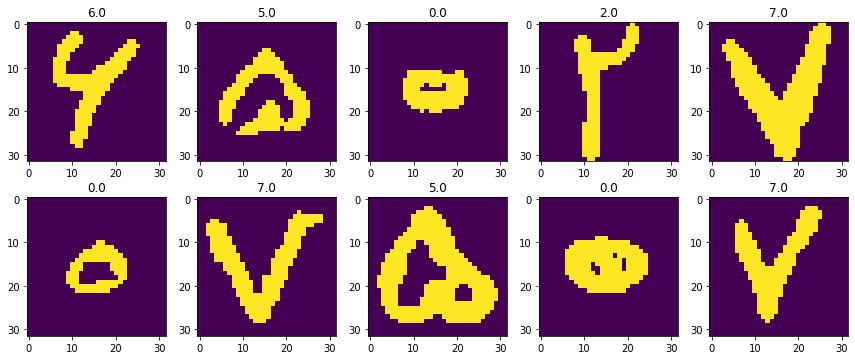

In [ ]:
plt.figure(figsize=(12,5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_train[i].reshape(32,32))
  plt.title(y_train[i])

plt.tight_layout()
plt.show()

#train the model with Traditional SVM

In [ ]:
from sklearn.svm import SVC
from time import perf_counter

start_tra = perf_counter()
hoda_svc = SVC(kernel='linear', C=np.inf)
hoda_svc.fit(X_train[:20000], y_train[:20000])
end_tra = perf_counter()
print(f'train phase time: ', round((end_tra-start_tra), 1))

In [ ]:
start_ts = perf_counter()
print('acc:', round(hoda_svc.score(X_test, y_test), 2))
end_ts = perf_counter()
print(f'test phase time: ', round((end_ts-start_ts), 1))

acc: 0.93
test phase time:  52.4


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
h_pars = {'kernel':['linear', 'rbf'], 'C':[0.01, 0.1, 1, np.inf]}
svc = SVC()
g_search = GridSearchCV(svc, h_pars, cv=4)
g_search.fit(X_train[:20000], y_train[:20000])
print(g_search.best_params_)
g_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_v

{'C': 1, 'kernel': 'rbf'}


0.9801000000000001

#train the model with ANNs

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_train

array([6., 5., 0., ..., 2., 6., 6.], dtype=float32)

In [ ]:
#one-hot encoding
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)

In [ ]:
##Import the libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import initializers, regularizers

In [ ]:
# Building the neural network
##define input layer
input_layer = Input(shape=(1024,), name='input_layer')
initializer = initializers.HeUniform()

##Defining 3 hidden layers
Layer_1 = Dense(512, activation="relu", name='Layer_1', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(1e-3))(input_layer)
Layer_2 = Dropout(0.5)(Layer_1)

Layer_3 = Dense(256, activation="relu", name='Layer_3', kernel_regularizer=regularizers.l2(1e-3))(Layer_2)
Layer_4 = Dropout(0.5)(Layer_3)

Layer_5 = Dense(128, activation='relu', kernel_regularizer='l2', name='Layer_5')(Layer_4)

##overfitting handling
Layer_6 = BatchNormalization()(Layer_5)
Layer_7 = Dropout(0.5)(Layer_6)

##Defining output layer
output = Dense(10, activation="softmax", name='output')(Layer_7)

##Defining the model by specifying the input and output layers
model = Model(inputs=input_layer, outputs=output)

In [ ]:
##summary of the model
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1024)]            0         
                                                                 
 Layer_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_45 (Dropout)        (None, 512)               0         
                                                                 
 Layer_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 Layer_5 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_15 (Ba  (None, 128)               512

In [ ]:
## defining the optimiser and loss function
from keras.optimizers import Adam
#from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score

adam = Adam(learning_rate=0.001, beta_1=0.91, beta_2=0.998)
#scce = SparseCategoricalCrossentropy()
#metric = F1Score()

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

##training the model
history = model.fit(X_train, y_train, epochs=100, verbose=True,
                    batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
469/469 [==============================] - 5s 7ms/step - loss: 1.9791 - accuracy: 0.8758 - val_loss: 0.9054 - val_accuracy: 0.9446
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6382 - accuracy: 0.9578 - val_loss: 0.4942 - val_accuracy: 0.9559
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4161 - accuracy: 0.9643 - val_loss: 0.4028 - val_accuracy: 0.9550
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3534 - accuracy: 0.9665 - val_loss: 0.3733 - val_accuracy: 0.9542
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3271 - accuracy: 0.9666 - val_loss: 0.3366 - val_accuracy: 0.9620
Epoch 6/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3195 - accuracy: 0.9669 - val_loss: 0.3256 - val_accuracy: 0.9633
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3127 - accuracy: 0.9680 - val_loss: 0.3152 - val_accuracy: 0.9657

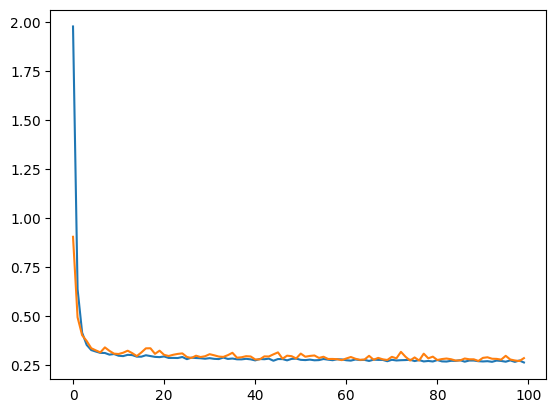

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
score = model.evaluate(X_test, y_test)
print("test loss: ",  score[0])
print("test accuracy: ",  score[1])

625/625 [==============================] - 2s 3ms/step - loss: 0.2859 - accuracy: 0.9641
test loss:  0.2858700752258301
test accuracy:  0.9641000032424927
